# Capstone Project - The Battle of the Neighborhoods

### Applied Data Science Capstone by IBM

### Table of contents
* Introduction: Business Problem
* Data
* Methodology
* Analysis
* Results and Discussion
* Conclusion

## Introduction: Business Problem

New York City is experiencing a Chinese food renaissance. Never before have the city’s offerings been so diverse; not only are multiple regions represented, but price points range, too. There are fast-casual spots like Xi’an Famous Foods, and there’s ambitious pan-regional fine dining like Atlas Kitchen. And where restaurateurs once needed to cater to Western tastes, many of today’s New York Chinese restaurants don’t have to so in order to survive.

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening a **Chinese restaurant** in **New York**, USA.

Since there are lots of restaurants in New York we will try to detect **the best location that are not already crowded with Chinese restaurants**. Moreover, we are also particularly interested in **areas with less competitor Chinese restaurants with good market reputation**.

We will use our data science powers to generate a few most promissing neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data

Based on definition of our problem, factors that will influence our decision are:

* number of existing Chinese restaurants in the neighborhood
* number of existing Chinese restaurants in the neighborhood with good market reputation(likes, tips etc.)

Following data sources will be needed to extract the required information:

* New York City data that contains list Boroughs, Neighborhoods along with their latitude and longitude.
* Data source : https://cocl.us/new_york_dataset
* Chinese restaurants in each neighborhood of New York city.
* Data source : Fousquare API

Before we get the data and start exploring it, let's download all the dependencies that we will need.

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes 
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes 
import folium # map rendering library

print('Libraries imported.')

Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - geopy


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    geographiclib-1.50         |             py_0          34 KB  conda-forge
    geopy-1.21.0               |             py_0          58 KB  conda-forge
    openssl-1.1.1g             |       h516909a_0         2.1 MB  conda-forge
    ------------------------------------------------------------
                                           Total:         2.2 MB

The following NEW packages will be INSTALLED:

  geographiclib      conda-forge/noarch::geographiclib-1.50-py_0
  geopy              conda-forge/noarch::geopy-1.21.0-py_0

The following packages will be UPDATED:

  openssl                                 1.1.1f-h516909a_0 --> 1.1.1g-h516909a_0



openssl-1.1.1g       | 2.1 MB    | ############

Load and explore the data

In [2]:
!wget -q -O 'newyork_data.json' https://cocl.us/new_york_dataset
print('Data downloaded!')

Data downloaded!


In [3]:
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

All the relevant data is in the features key, which is basically a list of the neighborhoods. So, let's define a new variable that includes this data.

In [4]:
neighborhoods_data = newyork_data['features']
neighborhoods_data[0]

{'type': 'Feature',
 'id': 'nyu_2451_34572.1',
 'geometry': {'type': 'Point',
  'coordinates': [-73.84720052054902, 40.89470517661]},
 'geometry_name': 'geom',
 'properties': {'name': 'Wakefield',
  'stacked': 1,
  'annoline1': 'Wakefield',
  'annoline2': None,
  'annoline3': None,
  'annoangle': 0.0,
  'borough': 'Bronx',
  'bbox': [-73.84720052054902,
   40.89470517661,
   -73.84720052054902,
   40.89470517661]}}

Next, transform this data of nested Python dictionaries into a pandas dataframe. So let's start by creating an empty dataframe.

In [5]:
# define the dataframe columns
column_names = ['Borough', 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
neighborhoods = pd.DataFrame(columns=column_names)

Then let's loop through the data and fill the dataframe one row at a time.

In [6]:
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    neighborhoods = neighborhoods.append({'Borough': borough,
                                          'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [7]:
neighborhoods.head()

,Borough,Neighborhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


And make sure that the dataset has all 5 boroughs and 306 neighborhoods.

In [8]:
print('The dataframe has {} boroughs and {} neighborhoods.'.format(
        len(neighborhoods['Borough'].unique()),
        neighborhoods.shape[0]
    )
)

The dataframe has 5 boroughs and 306 neighborhoods.


Use geopy library to get the latitude and longitude values of New York City.

In [9]:
address = 'New York City, NY'

geolocator = Nominatim(user_agent="ny_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7127281, -74.0060152.


Create a map of New York with neighborhoods superimposed on top.

In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighborhood in zip(neighborhoods['Latitude'], neighborhoods['Longitude'], neighborhoods['Borough'], neighborhoods['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

Define Foursquare Credentials and Version

In [11]:
# @hidden_cell
CLIENT_ID = 'JBREGZ4UNA53HX43WMAD4TQ2X2XJWMX5DPHEZEIZHQA0ACNP' 
CLIENT_SECRET = 'VNS40KF3V4MGSWWAV0IGQINZIGIT1EQKNCWBFPOS3QF1JMOJ' 
VERSION = '20180605' # Foursquare API version

Let's create a function to get the top 1000 venues that are in each neighborhood in New York city within a radius of 500 meters.

In [12]:
def getNearbyVenues(boroughs, names, latitudes, longitudes, radius=1000):
    
    LIMIT = 1000
    venues_list=[]
    for borough, name, lat, lng in zip(boroughs, names, latitudes, longitudes):
     
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            borough,
            name, 
            lat, 
            lng, 
            v['venue']['id'],
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = [ 'Borough',
                  'Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue ID',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

Run the above function on each neighborhood and create a new dataframe called newyork_venues.

In [13]:
newyork_venues = getNearbyVenues(boroughs=neighborhoods['Borough'],
                                   names=neighborhoods['Neighborhood'],
                                   latitudes=neighborhoods['Latitude'],
                                   longitudes=neighborhoods['Longitude']
                                  )

In [14]:
print(newyork_venues.shape)
newyork_venues.head()

(20546, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Wakefield,40.894705,-73.847201,4c537892fd2ea593cb077a28,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,Bronx,Wakefield,40.894705,-73.847201,4d375ce799fe8eec99fd2355,Ripe Kitchen & Bar,40.898152,-73.838875,Caribbean Restaurant
2,Bronx,Wakefield,40.894705,-73.847201,4c9e50e38afca09379b2ff15,Ali's Roti Shop,40.894036,-73.856935,Caribbean Restaurant
3,Bronx,Wakefield,40.894705,-73.847201,4c783cef3badb1f7e4244b54,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
4,Bronx,Wakefield,40.894705,-73.847201,4c10f6aece57c92804a682d2,Jackie's West Indian Bakery,40.889283,-73.843310,Caribbean Restaurant


Now we will obtain Chinese resturants for each Neighborhood.

In [15]:
newyork_cn_rest = newyork_venues[newyork_venues['Venue Category']=='Chinese Restaurant'].reset_index(drop=True)   
print(newyork_cn_rest.shape)
newyork_cn_rest.head()

(406, 9)


,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,Wakefield,40.894705,-73.847201,4edbac4e775bcc53fc0ed5f8,Hong Kong China King,40.891640,-73.840898,Chinese Restaurant
1,Bronx,Wakefield,40.894705,-73.847201,4e2710b7a809510950dd6b32,Double Dragon,40.892988,-73.857257,Chinese Restaurant
2,Bronx,Co-op City,40.874294,-73.829939,4c9d5f2654c8a1cd2e71834b,Guang Hui Chinese Restaurant,40.876651,-73.829092,Chinese Restaurant
3,Bronx,Co-op City,40.874294,-73.829939,4c66dcfaaebea593955a74d0,Chinese Buffet,40.880533,-73.823762,Chinese Restaurant
4,Bronx,Eastchester,40.887556,-73.827806,4dabc3dc93a04642f09ccabd,Xing Lung Chinese Restaurant,40.888785,-73.831226,Chinese Restaurant


## Methodology

In first step we have collected the required data: location, id, name, category etc. of every Chinese restaurant within each neighborhood according to Foursquare.

Second step in our analysis will be calculation and exploration of 'Chinese restaurant quantity' across different neighborhoods of New York - we will use bar chart to identify a few promising neighborhoods with low number of Chinese restaurants(the first requirment of business) and focus our attention on those areas.

In third and final step we will focus on the promising areas and within those create clusters of locations that meet the second requirements established in discussion with stakeholders: we will take into consideration locations with less competitor Chinese restaurants with good market reputation. We will present map of all such locations using k-means clustering of those locations to identify general neighborhoods which should be a starting point for final 'street level' exploration and search for optimal venue location by stakeholders.

## Analysis

Let's perform some basic explanatory data analysis and derive some additional info from our raw data. First let's count the number of Chinese restaurants in every neighborhood:

In [16]:
newyork_cn_grouped = newyork_cn_rest.groupby('Neighborhood').count()
newyork_cn_grouped.head()

,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,,,
Allerton,1,1,1,1,1,1,1,1
Arden Heights,1,1,1,1,1,1,1,1
Astoria Heights,2,2,2,2,2,2,2,2
Auburndale,2,2,2,2,2,2,2,2
Bath Beach,3,3,3,3,3,3,3,3


Let's sort the number of Chinese restaurants in every neighborhood in ascending order.

In [17]:
newyork_cn_sorted = newyork_cn_grouped.sort_values('Venue', ascending=True).reset_index(drop=False)
newyork_cn_sorted.head()

,Neighborhood,Borough,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Allerton,1,1,1,1,1,1,1,1
1,High Bridge,1,1,1,1,1,1,1,1
2,Heartland Village,1,1,1,1,1,1,1,1
3,Hammels,1,1,1,1,1,1,1,1
4,Parkchester,1,1,1,1,1,1,1,1


We can see there are many neighborhoods with only one Chinese restaurants, the promissing areas could be a little bit confusing to choose from.Therefore, let's zoom out to the borough level and have a try.

In [18]:
newyork_cn_grouped1 = newyork_cn_rest.groupby('Borough').count().reset_index(drop=False)
newyork_cn_grouped1.head()

,Borough,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue ID,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Bronx,70,70,70,70,70,70,70,70
1,Brooklyn,89,89,89,89,89,89,89,89
2,Manhattan,46,46,46,46,46,46,46,46
3,Queens,156,156,156,156,156,156,156,156
4,Staten Island,45,45,45,45,45,45,45,45


In [19]:
newyork_cn_grouped1.dtypes

Borough                   object
Neighborhood               int64
Neighborhood Latitude      int64
Neighborhood Longitude     int64
Venue ID                   int64
Venue                      int64
Venue Latitude             int64
Venue Longitude            int64
Venue Category             int64
dtype: object

In [20]:
newyork_cn_grouped1['Venue']=newyork_cn_grouped1['Venue'].astype('float64')

Let's create a bar chart to visualise the density of the Chinese restaurants in each borough.

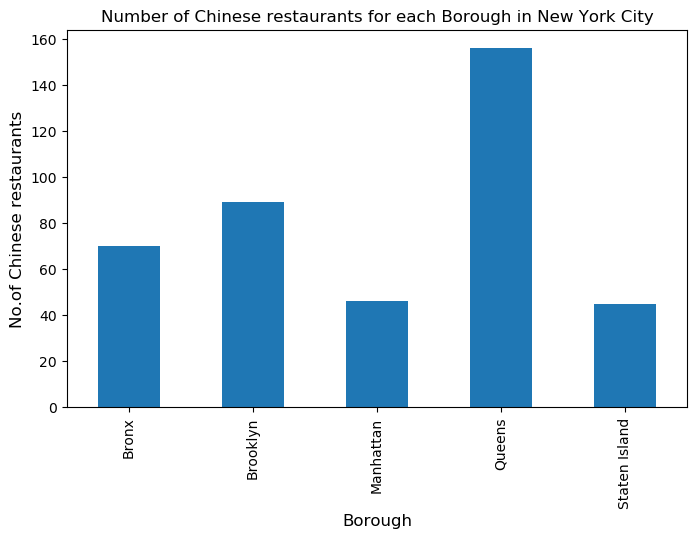

In [21]:
newyork_cn_grouped2 = newyork_cn_grouped1.set_index('Borough')

import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,5), dpi = 100)
plt.title('Number of Chinese restaurants for each Borough in New York City')
plt.xlabel('Borough', fontsize = 12)
plt.ylabel('No.of Chinese restaurants', fontsize=12)
newyork_cn_grouped2['Venue'].plot(kind='bar')

plt.show()

In the second step, as we can see from the above bar chart that Manhattan and Staten Island have the least number of Chinese restaurants, we choose Manhattan as the promising area because it is the center of New York city.

Define a function to get venue details like like count , rating , tip counts for a given venue id.

In [70]:
def getVenuesDetails(venue_id):
    
    CLIENT_ID = 'QEF4SFROUUVOQKNPAFNNRDUW4ACAWSYYG312LM3BKEDDKPIZ' # your Foursquare ID
    CLIENT_SECRET = 'CCBFW1WDVTUYDLPFX3SR0QBB5R2UKRYOZ3F1JDJ3PLQMPDRM' # your Foursquare Secret
    VERSION = '20180605'  # Foursquare API version
    
    # create the API request URL
    url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION)
            
    # make the GET request
    results = requests.get(url).json()['response']['venue']
        
    # return only relevant information for each nearby venue
    venues_details=[]
    venues_details.append([ 
            results['id'], 
            results['name'], 
            results['likes']['count'], 
            results['rating'],  
            results['tips']['count']
            ])

    column_names = ['Venue ID',
                  'Venue', 
                  'Likes', 
                  'Rating', 
                  'Tips']
    venues_details = pd.DataFrame(venues_details,columns=column_names)
    
    return(venues_details)

In [71]:
newyork_cn_rest.dtypes

Borough                    object
Neighborhood               object
Neighborhood Latitude     float64
Neighborhood Longitude    float64
Venue ID                   object
Venue                      object
Venue Latitude            float64
Venue Longitude           float64
Venue Category             object
dtype: object

In the last step we will get the ranking of each Chinese resturant for further analysis.

In [72]:
# prepare neighborhood list that contains Chinese resturants
column_names = ['Borough', 'Neighborhood', 'Venue ID','Venue','Likes','Rating','Tips']
newyork_cn_restrank=pd.DataFrame(columns=column_names)

for row in newyork_cn_rest.values.tolist():
    borough, neighborhood, neighborhood_latitude, neighborhood_longitude, venue_id, venue, venue_latitude, venue_longitude, venue_category=row
    try:
        venue_id,venue,likes,rating,tips = getVenuesDetails(venue_id).values.tolist()[0]
        
    except KeyError:
        # we will assign 0 value for these resturants as details does not exist in FourSquare Database
        venue_id,venue,likes,rating,tips = [0]*5
        
    newyork_cn_restrank = newyork_cn_restrank.append({'Borough': borough,
                                                'Neighborhood': neighborhood,  
                                                'Venue ID': venue_id,
                                                'Venue' : venue,
                                                'Likes' : likes,
                                                'Rating' : rating,
                                                'Tips' : tips
                                               }, ignore_index=True)

newyork_cn_restrank.head()

,Borough,Neighborhood,Venue ID,Venue,Likes,Rating,Tips
0,Bronx,Wakefield,0,0,0,0,0
1,Bronx,Wakefield,0,0,0,0,0
2,Bronx,Co-op City,0,0,0,0,0
3,Bronx,Co-op City,4c66dcfaaebea593955a74d0,Chinese Buffet,7,5,10
4,Bronx,Eastchester,0,0,0,0,0


In [73]:
newyork_cn_restrank.shape

(406, 7)

In [74]:
newyork_cn_restrank.dtypes

Borough         object
Neighborhood    object
Venue ID        object
Venue           object
Likes           object
Rating          object
Tips            object
dtype: object

We see that values like Likes, Rating, Tips are object, We need to convert them into float.

In [75]:
newyork_cn_restrank['Likes']=newyork_cn_restrank['Likes'].astype('float64')
newyork_cn_restrank['Rating']=newyork_cn_restrank['Rating'].astype('float64')
newyork_cn_restrank['Tips']=newyork_cn_restrank['Tips'].astype('float64')

In [76]:
newyork_cn_restrank.dtypes

Borough          object
Neighborhood     object
Venue ID         object
Venue            object
Likes           float64
Rating          float64
Tips            float64
dtype: object

Let's sort the average rating from a neighborhood level.

In [77]:
newyork_cn_restrating=newyork_cn_restrank.groupby('Neighborhood', as_index=False).sum()[['Neighborhood','Likes','Rating','Tips']]
newyork_cn_restrating.head(20)

,Neighborhood,Likes,Rating,Tips
0,Allerton,0.0,0.0,0.0
1,Arden Heights,0.0,0.0,0.0
2,Astoria Heights,0.0,0.0,0.0
3,Auburndale,0.0,0.0,0.0
4,Bath Beach,0.0,0.0,0.0
5,Bay Ridge,0.0,0.0,0.0
6,Bay Terrace,0.0,0.0,0.0
7,Baychester,1.0,6.8,8.0
8,Bayside,0.0,0.0,0.0
9,Bayswater,0.0,0.0,0.0


In [78]:
newyork_cn_restrating.sort_values(['Rating'],ascending=False, inplace=True)
newyork_cn_restrating.head(10)

,Neighborhood,Likes,Rating,Tips
129,Norwood,11.0,13.0,9.0
10,Bedford Park,11.0,13.0,9.0
61,Fordham,12.0,7.6,2.0
79,High Bridge,5.0,7.6,2.0
105,Marble Hill,3.0,7.4,5.0
138,Pelham Parkway,9.0,7.2,10.0
136,Parkchester,6.0,6.9,8.0
7,Baychester,1.0,6.8,8.0
109,Melrose,12.0,6.6,3.0
31,City Island,6.0,6.4,4.0


We select Manhattan only. Before that, we add back borough and location of each neighborhood.

In [89]:
newyork_cn_merg = newyork_cn_restrating.join(neighborhoods.set_index('Neighborhood'), on='Neighborhood')
newyork_cn_merg.head()

,Neighborhood,Likes,Rating,Tips,Borough,Latitude,Longitude
129,Norwood,11.0,13.0,9.0,Bronx,40.877224,-73.879391
10,Bedford Park,11.0,13.0,9.0,Bronx,40.870185,-73.885512
61,Fordham,12.0,7.6,2.0,Bronx,40.860997,-73.896427
79,High Bridge,5.0,7.6,2.0,Bronx,40.836623,-73.926102
105,Marble Hill,3.0,7.4,5.0,Manhattan,40.876551,-73.910660


In [90]:
# set borough as index
newyork_cn_merg = newyork_cn_merg.set_index('Borough')
newyork_cn_merg.head()

,Neighborhood,Likes,Rating,Tips,Latitude,Longitude
Borough,,,,,,
Bronx,Norwood,11.0,13.0,9.0,40.877224,-73.879391
Bronx,Bedford Park,11.0,13.0,9.0,40.870185,-73.885512
Bronx,Fordham,12.0,7.6,2.0,40.860997,-73.896427
Bronx,High Bridge,5.0,7.6,2.0,40.836623,-73.926102
Manhattan,Marble Hill,3.0,7.4,5.0,40.876551,-73.910660


In [91]:
# select Manhattan only
newyork_cn_merg = newyork_cn_merg.loc['Manhattan',]
newyork_cn_merg.head()

,Neighborhood,Likes,Rating,Tips,Latitude,Longitude
Borough,,,,,,
Manhattan,Marble Hill,3.0,7.4,5.0,40.876551,-73.910660
Manhattan,Morningside Heights,0.0,0.0,0.0,40.808000,-73.963896
Manhattan,Midtown,0.0,0.0,0.0,40.754691,-73.981669
Manhattan,Midtown South,0.0,0.0,0.0,40.748510,-73.988713
Manhattan,Noho,0.0,0.0,0.0,40.723259,-73.988434


Run k-means to cluster the neighborhood into 2 clusters.

In [96]:
# set number of clusters
kclusters = 2

manhattan_grouped_clustering = newyork_cn_merg.drop(['Neighborhood','Latitude','Longitude'], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(manhattan_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

Let's create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [97]:
# add clustering labels
newyork_cn_merg.insert(0, 'Cluster Labels', kmeans.labels_)
manhattan_merged = newyork_cn_merg
manhattan_merged.head() 

,Cluster Labels,Neighborhood,Likes,Rating,Tips,Latitude,Longitude
Borough,,,,,,,
Manhattan,1,Marble Hill,3.0,7.4,5.0,40.876551,-73.910660
Manhattan,0,Morningside Heights,0.0,0.0,0.0,40.808000,-73.963896
Manhattan,0,Midtown,0.0,0.0,0.0,40.754691,-73.981669
Manhattan,0,Midtown South,0.0,0.0,0.0,40.748510,-73.988713
Manhattan,0,Noho,0.0,0.0,0.0,40.723259,-73.988434


Finally, let's visualize the resulting clusters

In [98]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(manhattan_merged['Latitude'], manhattan_merged['Longitude'], manhattan_merged['Neighborhood'], manhattan_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

## Results and Discussion

Our analysis shows that although there is a great number of Chinese restaurants in New York city, there are boroughs of low Chinese restaurant density which are Manhattan and Staten Island. We never expect Manhattan has the the least Chinese restaurants compared to other boroughs. Highest concentration of restaurants was detected in Bronx, Brooklyn and Queens, so we focused our attention to areas Manhattan and Staten Island. Furthermore, our attention was focused on Manhattan which offers a combination of popularity among tourists, closeness to city center, strong socio-economic dynamics and a number of pockets of low Chinese restaurant density.

After directing our attention to this more narrow area of interest, we first created a list of popularity ranking of Chinese restaurants using Foursquare data of likes, rating and tips; then we can tell the locations with good market reputation should not be considered as the promising areas for new Chinese restaurants location, because of the fierce competition.

Those neighborhoods in Manhattan were then clustered to create zones shown on the map above. The red circles indicate areas with potential market for Chinese restaurants, the purple circles indicate areas with fierce market competition for Chinese restaurants. **Overall, we recommend the red circle areas on the map in Manhattan to open a new Chinese restaurant**.

The results may not be concise because of some limitations, one is the ranking depends purely on basis of rating of restaurants, the accuracy of data depends purely on the data provided by FourSquare. Another is the parameter set when we obtain the data from FourSquare, for example, the limitation set to 1000 and radius set to 1000 meters could be unreliable. Recommended zones should therefore be considered only as a starting point for more detailed analysis which could eventually result in location which has not only no nearby competition but also other factors taken into account and all other relevant conditions met.

## Conclusion 

Purpose of this project was to identify New York areas with low number of Chinese restaurants in order to aid stakeholders in narrowing down the search for optimal location for a new Chinese restaurant. By calculating Chinese restaurant number distribution from Foursquare data we have first identified general boroughs that justify further analysis (Manhattan), and then generated collection of locations which satisfy another requirement regarding existing nearby Chinese restaurants with good market reputation which are strong competitors. Clustering of those locations was then performed in order to create major zones of interest to be used as starting points for final exploration by stakeholders.

Final decission on optimal Chinese restaurant location will be made by stakeholders based on specific characteristics of neighborhoods and locations in every recommended zone, taking into consideration additional factors like attractiveness of each location, levels of noise / proximity to major roads, real estate availability, prices, social and economic dynamics of every neighborhood etc.